# LoRA 样例脚本

## 第一步：安装

安装 Data-Juicer 和 DiffSynth-Studio

In [ ]:
import os

!pip install simple-aesthetics-predictor
!git clone https://github.com/modelscope/data-juicer.git
!pip install -v -e data-juicer

!pip uninstall pytorch-lightning -y
!pip install peft lightning pandas torchvision
!git clone https://github.com/modelscope/DiffSynth-Studio.git
!pip install -e DiffSynth-Studio

# 请在这里手动重启 Notebook kernel

## 第二步：下载数据集

In [ ]:
from modelscope.msdatasets import MsDataset

ds = MsDataset.load(
    'AI-ModelScope/lowres_anime',
    subset_name='default',
    split='train',
    cache_dir="/mnt/workspace/data"
)

保存数据集中的图片及元数据

In [ ]:
import json, os
from data_juicer.utils.mm_utils import SpecialTokens
from tqdm import tqdm


os.makedirs("./data/lora_dataset/train", exist_ok=True)
os.makedirs("./data/data-juicer/input", exist_ok=True)
with open("./data/data-juicer/input/metadata.jsonl", "w") as f:
    for data_id, data in enumerate(tqdm(ds)):
        image = data["image"].convert("RGB")
        image.save(f"/mnt/workspace/data/lora_dataset/train/{data_id}.jpg")
        metadata = {"text": "二次元", "image": [f"/mnt/workspace/data/lora_dataset/train/{data_id}.jpg"]}
        f.write(json.dumps(metadata))
        f.write("\n")

## 第三步：数据处理

使用 data-juicer 处理数据

In [ ]:
data_juicer_config = """
# global parameters
project_name: 'data-process'
dataset_path: './data/data-juicer/input/metadata.jsonl'  # path to your dataset directory or file
np: 4  # number of subprocess to process your dataset

text_keys: 'text'
image_key: 'image'
image_special_token: '<__dj__image>'

export_path: './data/data-juicer/output/result.jsonl'

# process schedule
# a list of several process operators with their arguments
process:
    - image_shape_filter:
        min_width: 1024
        min_height: 1024
        any_or_all: any
    - image_aspect_ratio_filter:
        min_ratio: 0.5
        max_ratio: 2.0
        any_or_all: any
"""
with open("data/data-juicer/data_juicer_config.yaml", "w") as file:
    file.write(data_juicer_config.strip())

!dj-process --config data/data-juicer/data_juicer_config.yaml

保存处理好的数据

In [ ]:
import pandas as pd
import os, json
from PIL import Image
from tqdm import tqdm


texts, file_names = [], []
os.makedirs("./data/lora_dataset_processed/train", exist_ok=True)
with open("./data/data-juicer/output/result.jsonl", "r") as file:
    for data_id, data in enumerate(tqdm(file.readlines())):
        data = json.loads(data)
        text = data["text"]
        texts.append(text)
        image = Image.open(data["image"][0])
        image_path = f"./data/lora_dataset_processed/train/{data_id}.jpg"
        image.save(image_path)
        file_names.append(f"{data_id}.jpg")
data_frame = pd.DataFrame()
data_frame["file_name"] = file_names
data_frame["text"] = texts
data_frame.to_csv("./data/lora_dataset_processed/train/metadata.csv", index=False, encoding="utf-8-sig")
data_frame

## 第四步：训练模型

下载模型

In [ ]:
from diffsynth import download_models

download_models(["Kolors", "SDXL-vae-fp16-fix"])

查看训练脚本的输入参数

In [ ]:
!python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py -h

开始训练

提示：

1. 在训练命令中填入 `--modelscope_model_id xxxxx` 以及 `--modelscope_access_token xxxxx` 后，训练程序会在结束时自动上传模型到 ModelScope
2. 部分参数可根据实际需求调整，例如 `lora_rank` 可以控制 LoRA 模型的参数量

In [ ]:
import os

cmd = """
python DiffSynth-Studio/examples/train/kolors/train_kolors_lora.py \
  --pretrained_unet_path models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors \
  --pretrained_text_encoder_path models/kolors/Kolors/text_encoder \
  --pretrained_fp16_vae_path models/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors \
  --lora_rank 16 \
  --lora_alpha 4.0 \
  --dataset_path data/lora_dataset_processed \
  --output_path ./models \
  --max_epochs 1 \
  --center_crop \
  --use_gradient_checkpointing \
  --precision "16-mixed"
""".strip()

os.system(cmd)

加载模型

In [ ]:
from diffsynth import ModelManager, SDXLImagePipeline
from peft import LoraConfig, inject_adapter_in_model
import torch


def load_lora(model, lora_rank, lora_alpha, lora_path):
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        init_lora_weights="gaussian",
        target_modules=["to_q", "to_k", "to_v", "to_out"],
    )
    model = inject_adapter_in_model(lora_config, model)
    state_dict = torch.load(lora_path, map_location="cpu")
    model.load_state_dict(state_dict, strict=False)
    return model


# Load models
model_manager = ModelManager(torch_dtype=torch.float16, device="cuda",
                             file_path_list=[
                                 "models/kolors/Kolors/text_encoder",
                                 "models/kolors/Kolors/unet/diffusion_pytorch_model.safetensors",
                                 "models/kolors/Kolors/vae/diffusion_pytorch_model.safetensors"
                             ])
pipe = SDXLImagePipeline.from_model_manager(model_manager)

# Load LoRA
pipe.unet = load_lora(
    pipe.unet,
    lora_rank=16, # This parameter should be consistent with that in your training script.
    lora_alpha=2.0, # lora_alpha can control the weight of LoRA.
    lora_path="models/lightning_logs/version_0/checkpoints/epoch=0-step=500.ckpt"
)

生成图像

In [ ]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，一个紫色短发小女孩，在家中沙发上坐着，双手托着腮，很无聊，全身，粉色连衣裙",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("1.jpg")

In [ ]:
torch.manual_seed(1)
image = pipe(
    prompt="二次元，日系动漫，演唱会的观众席，人山人海，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙坐在演唱会的观众席，舞台上衣着华丽的歌星们在唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("2.jpg")

In [ ]:
torch.manual_seed(2)
image = pipe(
    prompt="二次元，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙坐在演唱会的观众席，露出憧憬的神情",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度，色情擦边",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("3.jpg")

In [ ]:
torch.manual_seed(5)
image = pipe(
    prompt="二次元，一个紫色短发小女孩穿着粉色吊带漏肩连衣裙，对着流星许愿，闭着眼睛，十指交叉，侧面",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度，扭曲的手指，多余的手指",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("4.jpg")

In [ ]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，一个紫色中等长度头发小女孩穿着粉色吊带漏肩连衣裙，在练习室练习唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("5.jpg")

In [ ]:
torch.manual_seed(1)
image = pipe(
    prompt="二次元，一个紫色长发小女孩穿着粉色吊带漏肩连衣裙，在练习室练习唱歌，手持话筒",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("6.jpg")

In [ ]:
torch.manual_seed(7)
image = pipe(
    prompt="二次元，紫色长发少女，穿着黑色连衣裙，试衣间，心情忐忑",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("7.jpg")

In [ ]:
torch.manual_seed(0)
image = pipe(
    prompt="二次元，紫色长发少女，穿着黑色礼服，连衣裙，在台上唱歌",
    negative_prompt="丑陋、变形、嘈杂、模糊、低对比度",
    cfg_scale=4,
    num_inference_steps=50, height=1024, width=1024,
)
image.save("8.jpg")

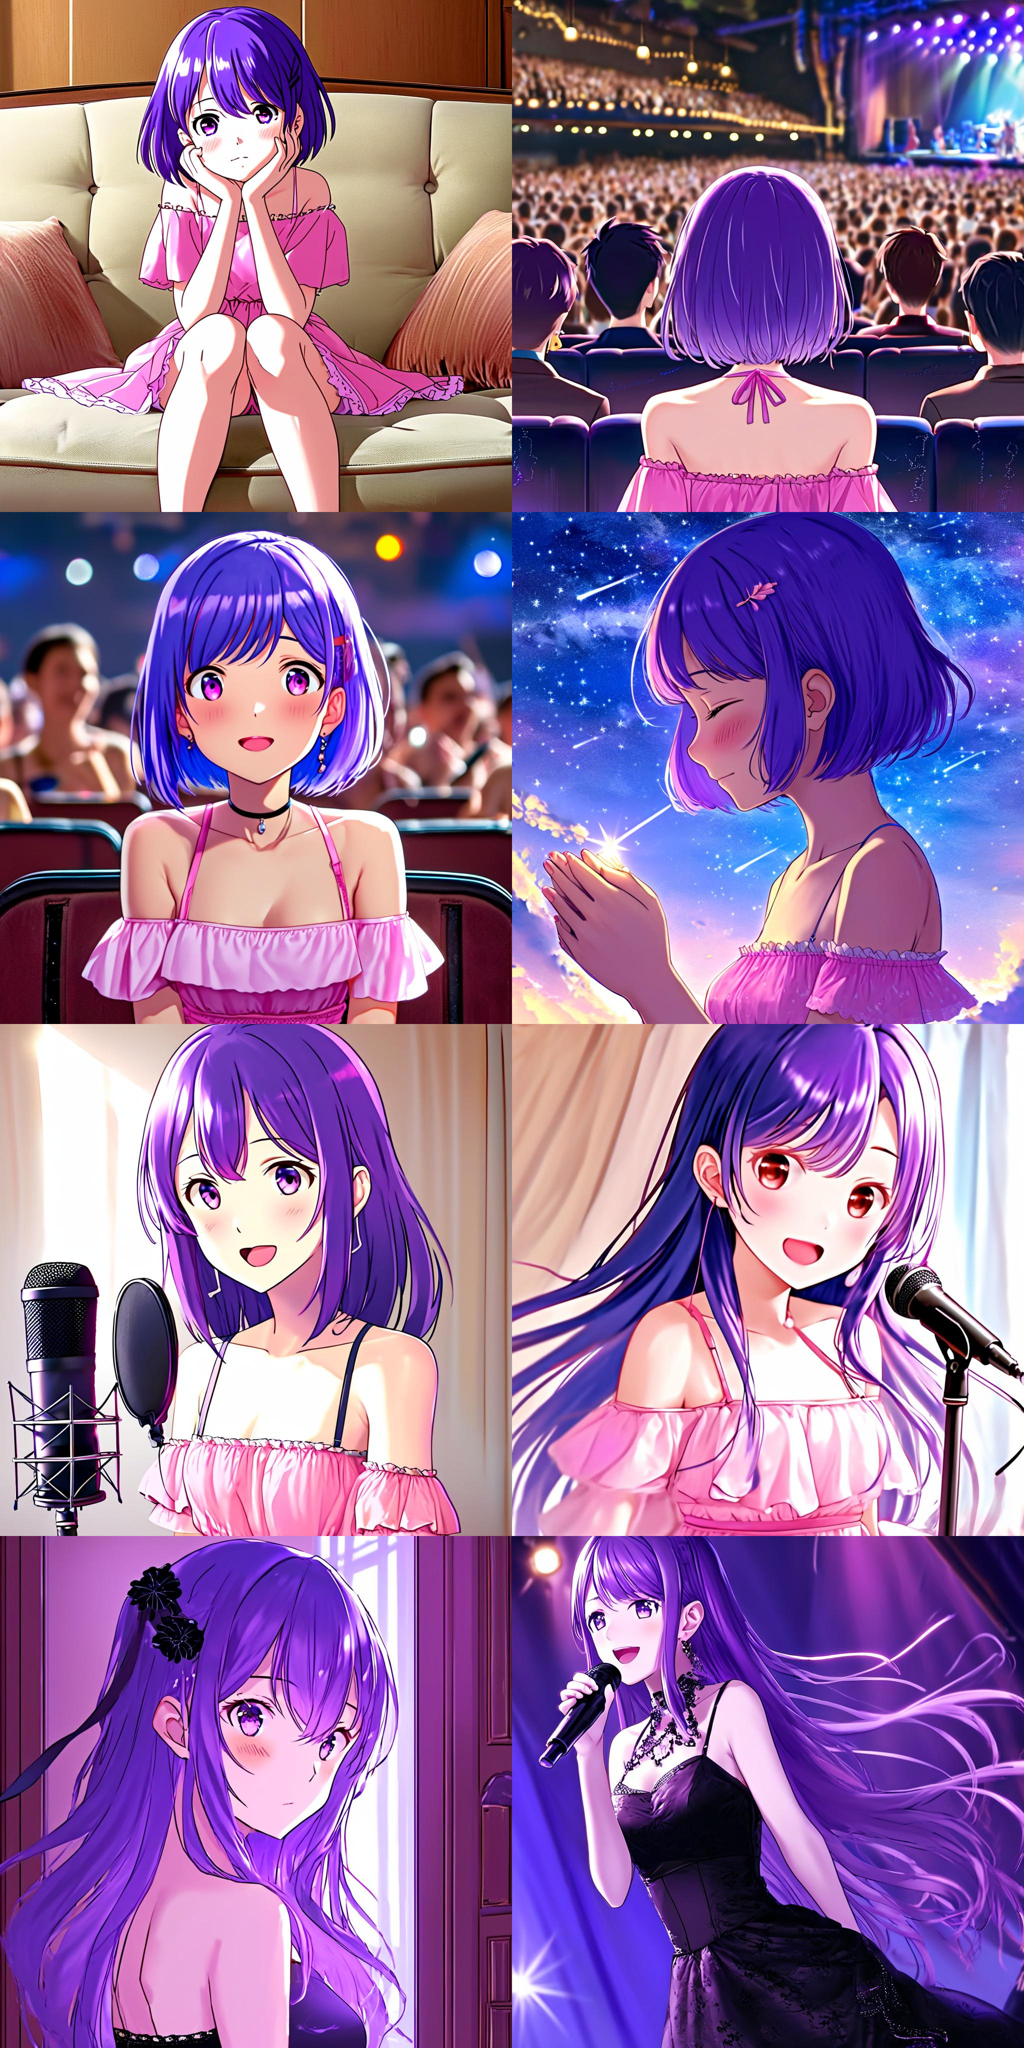

In [1]:
import numpy as np
from PIL import Image


images = [np.array(Image.open(f"{i}.jpg")) for i in range(1, 9)]
image = np.concatenate([
    np.concatenate(images[0:2], axis=1),
    np.concatenate(images[2:4], axis=1),
    np.concatenate(images[4:6], axis=1),
    np.concatenate(images[6:8], axis=1),
], axis=0)
image = Image.fromarray(image).resize((1024, 2048))
image